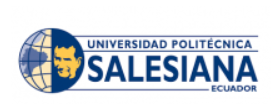

### Integrantes:

Francisco Pelaez

Diana Tixi

### Análisis Multivariante con Clustering

#### Analisis Descriptivo

- Number: Identificador unico del paciente 
- Age:Edad del Paciente
- Gender: Genero del Paciente
- Fever:Fiebre
- Dyspnea: Dificultad al respirar 
- Nasal:Congestion Nasal
- Cough:Tos
- PO2: Presion Parcial de Oxigeno
- CRP: Cantidad de Proteina c-reactiva en la sangre
- Asthenia: Sensacion de falta de fuerzas
- Leukopenia: Trastorno de la sangre producida por la baja de produccion de leucocitos o globulos   balncos 
- Exposure to Covid-19 Patients: Exposicion a pacientes con Covid-19
- High risk zone: Zona de alto riesgo 
- Temp: Temperatura 
- Blood Test: Prueba de sangre 
- RT-PCR: Reaccion en cadena de polimerasa con transcriptasa reversa (prueba ADN )
- History: Historial Clinico
- Decision Label: Salida --> Covid 19 - Gripe

In [1]:
## LIBRERIAS 
import pandas as pd
import numpy as np
from numpy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import math
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import cdist
import statistics as stats 
import seaborn as sns
import sympy as sp
from mpl_toolkits.mplot3d import axes3d
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import string

#### 3.2	Cargar dataset Covid-19 - Clasificacion

In [2]:
# 4.1 Cargar el Dataset
url= "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/LQDFSE/IGUJFG"
df=pd.read_csv(url, delimiter ='\t')
df.head()
df

,Number,Age,Gender,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Asthenia,Leukopenia,ExposuretoCovid-19patients,Highriskzone,Temp,BloodTest,RT-PCR,History,Decisionlabel
0,1.0,80,Male,Yes,Yes,Yes,*,*,*,*,*,*,*,*,*,*,*,COVID-19
1,2.0,62,Male,Yes,*,Yes,Yes,97,0.75,Yes,*,*,*,*,*,*,*,COVID-19
2,3.0,57,Male,Yes,*,Yes,Yes,*,*,*,*,Yes,*,*,*,*,*,COVID-19
3,4.0,45,Male,Yes,*,Yes,Yes,*,*,*,Yes,Yes,*,*,*,*,*,COVID-19
4,5.0,63,Male,Yes,*,Yes,Yes,*,*,*,Yes,Yes,*,*,*,*,*,COVID-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,126.0,62,Female,No,*,No,Yes,*,*,No,*,No,Yes,38.299999999999997,*,*,*,Flu
126,127.0,63,Male,Yes,*,No,Yes,*,*,No,*,No,Yes,38.5,*,*,*,Flu
127,128.0,63,Female,Yes,*,No,Yes,*,*,No,*,No,Yes,39.299999999999997,*,*,*,Flu
128,129.0,40,Female,No,*,No,No,*,*,No,*,No,Yes,*,*,*,*,Flu


####  3.3	Desarrollar procesamiento de datos: limpiar ruido, transformar variables categóricas en numéricas, transformación de datos numéricos (estandarización, normalización MinMax, L1, L2, Scaling)

In [3]:
df.columns = ['Number','Age','Gender','Fever','Dyspnea','Nasal','Cough','PO2','CRP','Astenia','Leukopenia','ExposuretoCovid-19patients','Highriskzone','Temp','BloodTest','RT-PCR','History','Decisionlabel']
df= df.replace('*', 0)
df['Gender']=df['Gender'].replace(to_replace=0, value='Other')
df['Fever']=df['Fever'].replace({'Yes':1, 'No':0})
df['Dyspnea']=df['Dyspnea'].replace({ 'Yes':1, 'No':0})
df['Nasal']=df['Nasal'].replace({'Yes':1, 'No':0})
df['Cough']=df['Cough'].replace({'Yes':1, 'No':0})
df['Astenia']=df['Astenia'].replace({'Yes':1, 'No':0})
df['Leukopenia']=df['Leukopenia'].replace({'Yes':1, 'No':0})
df['Highriskzone']=df['Highriskzone'].replace({'Yes':1, 'No' :0})
df['History']=df['History'].replace(to_replace=0, value='None')
df['History']=df['History'].replace(to_replace='Croonic', value='Chronic')
df['ExposuretoCovid-19patients']=df['ExposuretoCovid-19patients'].replace({'Yes':1, 'No':0 , 'No ':0})
df['Decisionlabel']=df['Decisionlabel'].replace({'COVID-19':1, 'Flu':0})
df['Temp']=df['Temp'].fillna(0)

Xsubset= df[['Age','Gender','Fever' ,'Dyspnea','Nasal','Cough','PO2','CRP','Astenia','Leukopenia','ExposuretoCovid-19patients','Highriskzone','Temp','History','Decisionlabel']]
#Xsubset

In [4]:
#Preporcesamiento de Datos
procesado = make_column_transformer(
    (StandardScaler(),['Age','Fever' ,'Dyspnea','Nasal','Cough','PO2','CRP','Astenia','Leukopenia','ExposuretoCovid-19patients','Highriskzone','Temp']),
    (OneHotEncoder(),['Gender','History'])
    )

X = procesado.fit_transform(Xsubset)
categorical_features = ['Gender','History']
nombresData1 = ['Age','Fever' ,'Dyspnea','Nasal','Cough','PO2','CRP','Astenia','Leukopenia','ExposuretoCovid-19patients','Highriskzone','Temp']
nombresData2 = procesado.transformers_[1][1].get_feature_names(categorical_features)
nombresData1.extend(nombresData2)
procesadoF = pd.DataFrame(data=X,columns=nombresData1)
#procesadoF.to_csv("DatosProcesadosCovid.csv", sep=";",index = False)
#procesadoF

In [5]:
salida=Xsubset['Decisionlabel']
datos=pd.concat([procesadoF, salida],axis=1)
#datos.to_csv("DatosProcesadosCovid19.csv", sep=";",index = False)
datos

,Age,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Astenia,Leukopenia,ExposuretoCovid-19patients,...,Gender_Male,Gender_Other,History_Asthma,History_COPD,History_Chronic,History_Colon Cancer,History_DM,History_Kidney cancer,History_None,Decisionlabel
0,1.088330,0.727607,1.680336,2.101587,-1.063554,-0.452014,-0.150315,-0.361158,-0.178174,-0.333333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,0.164209,0.727607,-0.595119,2.101587,0.940244,1.863791,0.137504,2.768875,-0.178174,-0.333333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,-0.092491,0.727607,-0.595119,2.101587,0.940244,-0.452014,-0.150315,-0.361158,-0.178174,3.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
3,-0.708571,0.727607,-0.595119,2.101587,0.940244,-0.452014,-0.150315,-0.361158,5.612486,3.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.215549,0.727607,-0.595119,2.101587,0.940244,-0.452014,-0.150315,-0.361158,5.612486,3.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0.164209,-1.374369,-0.595119,-0.475831,0.940244,-0.452014,-0.150315,-0.361158,-0.178174,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
126,0.215549,0.727607,-0.595119,-0.475831,0.940244,-0.452014,-0.150315,-0.361158,-0.178174,-0.333333,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
127,0.215549,0.727607,-0.595119,-0.475831,0.940244,-0.452014,-0.150315,-0.361158,-0.178174,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
128,-0.965271,-1.374369,-0.595119,-0.475831,-1.063554,-0.452014,-0.150315,-0.361158,-0.178174,-0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


#### 3.4	Realizar estadística descriptiva (medidas: media, varianza, correlaciones, etc) de toda la población: buscar variables influyentes.

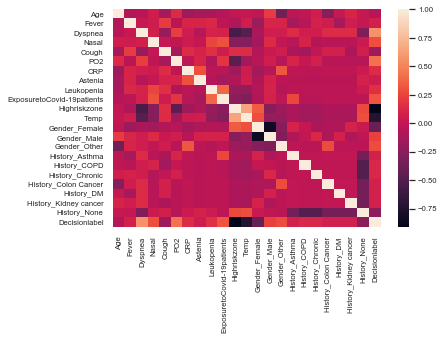

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(font_scale=0.7)
correlacion = datos.corr()
sb.heatmap(correlacion)

In [7]:
correl=datos.corr()
correl=round(correl,5)
correl
#with open('correlacionD.tex','w') as tf:tf.write(correl.to_latex())

,Age,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Astenia,Leukopenia,ExposuretoCovid-19patients,...,Gender_Male,Gender_Other,History_Asthma,History_COPD,History_Chronic,History_Colon Cancer,History_DM,History_Kidney cancer,History_None,Decisionlabel
Age,1.00000,-0.07465,-0.03887,0.06694,-0.12607,0.13704,-0.15266,-0.12364,-0.11939,-0.05321,...,0.21610,-0.36556,-0.01718,-0.00835,0.06866,-0.26580,0.02350,0.10486,0.02533,-0.06350
Fever,-0.07465,1.00000,0.02830,0.05450,0.22306,-0.03320,0.10937,0.11095,0.12964,-0.02695,...,0.11206,0.10502,-0.12101,-0.04042,0.09095,0.06406,-0.12101,0.06406,0.01553,0.08218
Dyspnea,-0.03887,0.02830,1.00000,0.07773,-0.17699,0.22828,0.06504,-0.05057,0.09668,0.09335,...,0.06254,0.07063,0.14795,0.06783,0.06783,0.14795,0.14795,0.14795,-0.28462,0.56826
Nasal,0.06694,0.05450,0.07773,1.00000,0.01039,-0.00965,0.04831,0.01432,0.25964,0.30400,...,0.14107,-0.00219,-0.04189,0.10161,-0.05948,-0.04189,-0.04189,-0.04189,0.03935,0.29557
Cough,-0.12607,0.22306,-0.17699,0.01039,1.00000,-0.12736,0.14133,0.09835,0.16753,0.05652,...,0.03371,0.06433,-0.09364,-0.13294,-0.00771,0.08278,0.08278,-0.09364,0.07993,-0.15715
PO2,0.13704,-0.03320,0.22828,-0.00965,-0.12736,1.00000,-0.01024,0.10577,-0.08054,0.18969,...,0.06587,-0.04155,0.10734,0.01811,0.08824,-0.03980,-0.03980,-0.03980,-0.05008,0.43161
CRP,-0.15266,0.10937,0.06504,0.04831,0.14133,-0.01024,1.00000,0.30376,-0.02678,-0.05011,...,-0.05044,0.32734,-0.01323,-0.01879,-0.01879,-0.01323,-0.01323,-0.01323,0.03849,0.14353
Astenia,-0.12364,0.11095,-0.05057,0.01432,0.09835,0.10577,0.30376,1.00000,-0.06435,-0.12039,...,0.08900,-0.02329,-0.03180,-0.04514,-0.04514,-0.03180,-0.03180,-0.03180,0.09248,0.05562
Leukopenia,-0.11939,0.12964,0.09668,0.25964,0.16753,-0.08054,-0.02678,-0.06435,1.00000,0.38604,...,0.09741,-0.05417,-0.01569,-0.02227,-0.02227,-0.01569,-0.01569,-0.01569,0.04563,0.17013
ExposuretoCovid-19patients,-0.05321,-0.02695,0.09335,0.30400,0.05652,0.18969,-0.05011,-0.12039,0.38604,1.00000,...,0.09241,-0.00921,0.26414,-0.04167,-0.04167,-0.02935,-0.02935,-0.02935,-0.02134,0.31829


In [8]:
medidas=datos.describe()
medidas=round(medidas)
medidas
#with open('medidadDes.tex','w') as tf:tf.write(medidas.to_latex())

,Age,Fever,Dyspnea,Nasal,Cough,PO2,CRP,Astenia,Leukopenia,ExposuretoCovid-19patients,...,Gender_Male,Gender_Other,History_Asthma,History_COPD,History_Chronic,History_Colon Cancer,History_DM,History_Kidney cancer,History_None,Decisionlabel
count,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,...,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
mean,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
min,-3.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-1.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
50%,0.0,1.0,-1.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
75%,1.0,1.0,2.0,-0.0,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
max,2.0,1.0,2.0,2.0,1.0,7.0,9.0,3.0,6.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### Anlisis de las variables que influyen en la salida 

In [9]:
VariablesI= datos[['Dyspnea', 'PO2', 'ExposuretoCovid-19patients','Highriskzone', 'Temp','Decisionlabel']]
#VariablesI
#with open('VariablesInfluyentes.tex','w') as tf:tf.write(medidas.to_latex())

In [10]:
correl=VariablesI.corr()
correl=round(correl,5)
#correl
#with open('correlacionVariablesI.tex','w') as tf:tf.write(medidas.to_latex())

In [11]:
v1=VariablesI['Dyspnea'].corr(VariablesI['Decisionlabel'])
v2=VariablesI['PO2'].corr(VariablesI['Decisionlabel'])
v3=VariablesI['ExposuretoCovid-19patients'].corr(VariablesI['Decisionlabel'])
v4=VariablesI['Highriskzone'].corr(VariablesI['Decisionlabel'])
v5=VariablesI['Temp'].corr(VariablesI['Decisionlabel'])


# 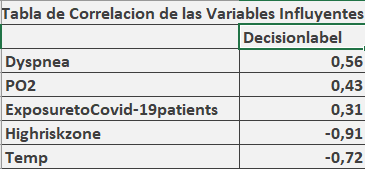

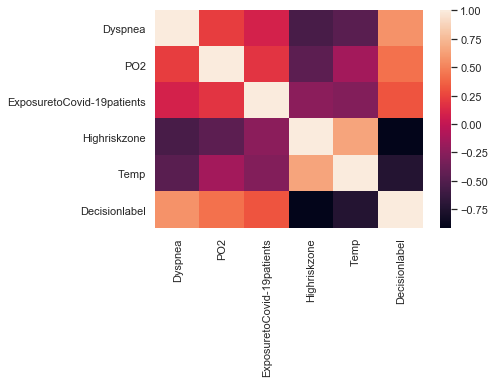

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(font_scale=1)
correlacion = VariablesI.corr()
sb.heatmap(correlacion)
#with open('mapaCorrelacionVI.tex','w') as tf:tf.write(correl.to_latex())

In [13]:
medidas=VariablesI.describe()
medidas=round(medidas)
medidas
#with open('medidasVariablesI.tex','w') as tf:tf.write(medidas.to_latex())

,Dyspnea,PO2,ExposuretoCovid-19patients,Highriskzone,Temp,Decisionlabel
count,130.0,130.0,130.0,130.0,130.0,130.0
mean,0.0,-0.0,0.0,-0.0,0.0,1.0
std,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.0,-0.0,-0.0,-1.0,-1.0,0.0
25%,-1.0,-0.0,-0.0,-1.0,-1.0,0.0
50%,-1.0,-0.0,-0.0,1.0,1.0,1.0
75%,2.0,-0.0,-0.0,1.0,1.0,1.0
max,2.0,7.0,3.0,1.0,1.0,1.0


#### 3.5 Realizar Clustering

In [14]:
#Metodo Elbow
from time import time 
K_range=range(2,20,1)
distortions=[]
tiempoTotal=[]

for i in K_range:
    tiempo_I = time()
    kmeanModel = KMeans(n_clusters=i,init='k-means++')
    kmeanModel.fit(datos)
    distortions.append(sum(np.min(cdist(datos, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / datos.shape[0])
    tiempo_F=time()
    tiempo_C= tiempo_F - tiempo_I
    tiempoTotal.append(tiempo_C)
print('Kmeans terminado')


Kmeans terminado


Text(0.5, 1.0, 'Metodo del Codo')

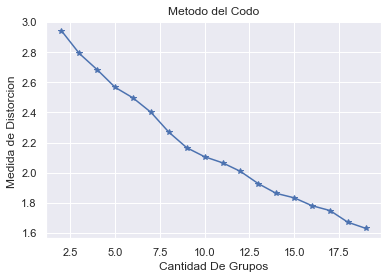

In [15]:
fig1=plt.figure()
ex = fig1.add_subplot(111)
ex.plot(K_range, distortions, 'b*-')
plt.grid(True)
plt.xlabel('Cantidad De Grupos')
plt.ylabel('Medida de Distorcion ')
plt.title('Metodo del Codo')


In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.cluster import KMeans

#Datamining: Clustering (método no supervisado de Machine Learning)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

#Kmeans Clustering 
#datos y la cantidad de cluster que deseamos encontrar (2 grupos seria lo minimo)
def doKmeans(X, nclust=2, init='k-means++',max_iter=100, tol=0.0001, random_state=10, algorithm='full'):
    model = KMeans(nclust)
    model.fit(X) #Entrenamiento
    clust_labels = model.predict(X) # Prediccion (Etiquetas)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(datos, 20, init='k-means++',max_iter=100, tol=0.0001, random_state=10, algorithm='full' )
#kmeans = pd.DataFrame(clust_labels)
kmeans = pd.DataFrame(clust_labels,columns=['Grupos'])
#kmeans
#asignacion de los usuario a cada claster  
print('Usuarios agrupados')

Usuarios agrupados


In [17]:
kmeans
UserGrupoK=kmeans.groupby(kmeans.Grupos).Grupos.count()

UserGrupoK=UserGrupoK.sort_values(ascending=False, inplace=False, kind='quicksort')
UserGrupoK

Grupos
13    17
19    12
2     11
6     11
8      9
9      9
11     8
12     7
5      7
1      7
10     6
16     6
0      6
4      4
3      3
15     2
17     2
14     1
18     1
7      1
Name: Grupos, dtype: int64

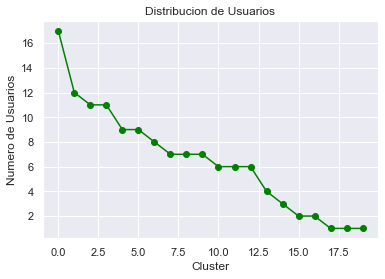

In [18]:
grupo=UserGrupoK.index.tolist()
valores=UserGrupoK.values.tolist()

plt.rcParams.update({'font.size': 10})
#plt.bar(range(len(grupo)), valores, color='red')
plt.plot(range(len(grupo)), valores, color='green', marker='o')
#plt.figure(figsize=(8,3))
##Pone el valor de los indices en el eje x
#plt.xticks(range(len(grupo)), grupo, rotation='vertical')
plt.title("Distribucion de Usuarios")
plt.xlabel("Cluster")
plt.ylabel("Numero de Usuarios")
plt.grid(True)
plt.show()


#### 3.7 Reduccion Dimensionalidad 

In [19]:
num_components=23
pca = PCA(num_components)
principalComponents = pca.fit_transform(datos)

explained_variance=pca.explained_variance_ratio_
explained_variance
print('Varianzas:')
print(np.around(explained_variance, decimals=3))
a = range(num_components)
num_pc= a[::1]

principalDf = pd.DataFrame(data = principalComponents
             , columns = num_pc)

principalDf=round(principalDf, 2)
#print(principalDf)

Varianzas:
[0.224 0.131 0.119 0.084 0.075 0.072 0.057 0.053 0.049 0.042 0.036 0.027
 0.016 0.006 0.004 0.002 0.001 0.001 0.001 0.001 0.    0.    0.   ]


#### 3.8	Realizar un Split con 20% en Test.

In [20]:
# Splitting dataset en conjunto de training y conjunto de Test
from sklearn.model_selection import train_test_split
X= datos.drop('Decisionlabel',1)
y=datos['Decisionlabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
#print(X_test)

(104, 22)
(26, 22)
(104,)
(26,)


#### 3.9	Diseñar un modelo de Machine Learning: orientado a clasificación (random forest) o a regresión (regresión multi variable)

In [21]:
#Metodo de Random Forest aplicando PCA sin especificar los componentes 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
#Training and Making Predictions
#In this case we'll use random forest classification for making the predictions.
import time 
tiempoT = []

pca=PCA()
X_train_pca = pca.fit_transform(X_train)
# Predicting the Test set results
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

tiempoIni=time.time()
classifier = RandomForestClassifier(max_depth=2, random_state=0)  
classifier.fit(X_train, y_train)

y_pred_pca = classifier.predict(X_test_pca)

cm = confusion_matrix(y_test, y_pred_pca)

print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred_pca)))

tiempoFin = time.time()
tiempoT.append(tiempoFin-tiempoIni)

print('Tiempo en Milisegundos', tiempoT)

[[ 4  5]
 [ 4 13]]
Accuracy: 0.6538461538461539
Tiempo en Milisegundos [0.4165329933166504]


In [22]:
pca = PCA()  
#pca = PCA(n_components=2)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test) 
explained_variance = pca.explained_variance_ratio_  
print(explained_variance)

[2.15471701e-01 1.45005114e-01 1.24516489e-01 9.09570086e-02
 7.67067712e-02 6.64216836e-02 5.66542898e-02 5.36313709e-02
 4.75673965e-02 3.98567988e-02 3.36473564e-02 2.46046370e-02
 1.41863768e-02 4.14193448e-03 3.67470321e-03 1.05681513e-03
 6.63078442e-04 6.62368064e-04 5.74106690e-04 3.51204674e-34
 1.80423685e-35 1.31139065e-37]


In [23]:
#Training and Making Predictions
#In this case we'll use random forest classification for making the predictions.
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)  
y_pred

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1], dtype=int64)

In [24]:
#EVALUACION
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('accuracy: ' + str(accuracy_score(y_test, y_pred))) 

[[ 9  0]
 [ 0 17]]
accuracy: 1.0


#### Analisis de Random Forest especifincando el numero de componentes

In [25]:
#PROCESO PCA CON N_COMPONENTS. LA MAYOR CANTIDAD DE COMPONENTES NO GARANTIZA UN MEJOR RESULTADO
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

from sklearn.decomposition import PCA

#pca = PCA()  
pca = PCA(n_components=18)  
X_train = pca.fit_transform(X_train)  
X_test = pca.transform(X_test) 

explained_variance = pca.explained_variance_ratio_  
print(explained_variance)

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test) 

from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('accuracy: ' + str(accuracy_score(y_test, y_pred))) 

[0.15728569 0.10633763 0.10437951 0.08630176 0.07055072 0.06292935
 0.05532021 0.05281187 0.04457579 0.04189428 0.03783797 0.03426837
 0.0303395  0.02814647 0.02527174 0.01968096 0.01787147 0.0168961 ]
[[ 8  1]
 [ 0 17]]
accuracy: 0.9615384615384616


In [26]:
#PROCESO SIN PCA

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()  
X_train = sc.fit_transform(X_train)  
X_test = sc.transform(X_test) 

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)  
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test) 

from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)  
print(cm)  
print('accuracy: ' + str(accuracy_score(y_test, y_pred)))  

[[ 9  0]
 [ 1 16]]
accuracy: 0.9615384615384616


#### Analis de Random Forest sin PCA 

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

vecAccu =[]
vecCom =[]
for i in range (1,23):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


    sc = StandardScaler()  
    X_train = sc.fit_transform(X_train)  
    X_test = sc.transform(X_test) 

    #pca = PCA()  
    pca = PCA(n_components=i)  
    X_train = pca.fit_transform(X_train)  
    X_test = pca.transform(X_test) 

    explained_variance = pca.explained_variance_ratio_  
    #print(explained_variance)

    from sklearn.ensemble import RandomForestClassifier

    classifier = RandomForestClassifier(max_depth=2, random_state=0)  
    classifier.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier.predict(X_test) 

    vecCom.append(i)
    vecAccu.append((accuracy_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)  
    #print(cm)  
    print('Componente: ' + str(i) + ' - Accuracy: ' + str("{0:.4f}".format(accuracy_score(y_test, y_pred))) ) 

Componente: 1 - Accuracy: 0.9615
Componente: 2 - Accuracy: 0.9615
Componente: 3 - Accuracy: 0.9615
Componente: 4 - Accuracy: 0.9615
Componente: 5 - Accuracy: 0.9615
Componente: 6 - Accuracy: 0.9615
Componente: 7 - Accuracy: 0.9615
Componente: 8 - Accuracy: 0.9615
Componente: 9 - Accuracy: 0.9615
Componente: 10 - Accuracy: 0.9615
Componente: 11 - Accuracy: 0.9615
Componente: 12 - Accuracy: 0.9615
Componente: 13 - Accuracy: 0.9615
Componente: 14 - Accuracy: 0.9231
Componente: 15 - Accuracy: 0.9231
Componente: 16 - Accuracy: 0.9615
Componente: 17 - Accuracy: 0.9615
Componente: 18 - Accuracy: 0.9615
Componente: 19 - Accuracy: 0.9615
Componente: 20 - Accuracy: 0.9615
Componente: 21 - Accuracy: 0.9615
Componente: 22 - Accuracy: 0.9615


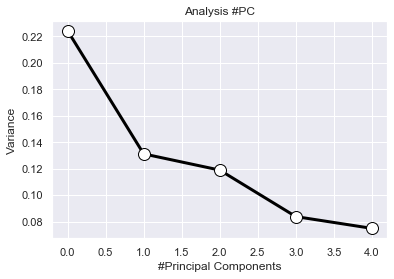

In [28]:
from sklearn.decomposition import PCA
#Visualize 2D Projection
import matplotlib.pyplot as plt

num_components=5
pca = PCA(num_components)
principalComponents = pca.fit_transform(datos)
a = range(num_components)
num_pc= a[::1]

explained_variance=pca.explained_variance_ratio_
explained_variance
a = range(num_components)
num_pc= a[::1]
plt.plot(num_pc, explained_variance, color='black', linestyle='solid', linewidth = 3, 
         marker='o', markerfacecolor='white', markersize=12)

plt.title('Analysis #PC')
plt.xlabel('#Principal Components')
plt.ylabel('Variance')
plt.show()



In [29]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = num_pc)
correl=principalDf.corr()
correl=round(correl,6)
correl

,0,1,2,3,4
0,1.0,0.0,-0.0,0.0,0.0
1,0.0,1.0,-0.0,-0.0,-0.0
2,-0.0,-0.0,1.0,0.0,-0.0
3,0.0,-0.0,0.0,1.0,-0.0
4,0.0,-0.0,-0.0,-0.0,1.0


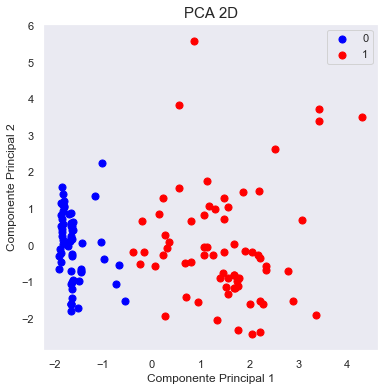

In [30]:
import matplotlib.pyplot as plt
pca2=PCA(2)
compP2d=pca2.fit_transform(datos)
compPrin2d= pd.DataFrame(data=compP2d,
                          columns=['Componente1','Componente2'])
compPrin2d=pd.concat([compPrin2d,datos[['Decisionlabel']]],axis=1)
fig = plt.figure(figsize = (6,6))
ax=fig.add_subplot(1,1,1)
ax.set_xlabel('Componente Principal 1', fontsize=12)
ax.set_ylabel('Componente Principal 2', fontsize=12)
ax.set_title('PCA 2D',fontsize=15)
salida=[0,1]
colors=['blue','red']
targets = ['Normal', 'Ischemic changes ', 'Old Anterior Myocardial Infarction','Old Inferior Myocardial Infarction']
for i, color in zip(salida,colors):
    indicesToKeep = compPrin2d['Decisionlabel'] == i
    ax.scatter(compPrin2d.loc[indicesToKeep, 'Componente1']
               , compPrin2d.loc[indicesToKeep, 'Componente2']
               , c=color
               , s=50)
ax.legend(salida)
ax.grid()
plt.show()

<IPython.core.display.Javascript object>


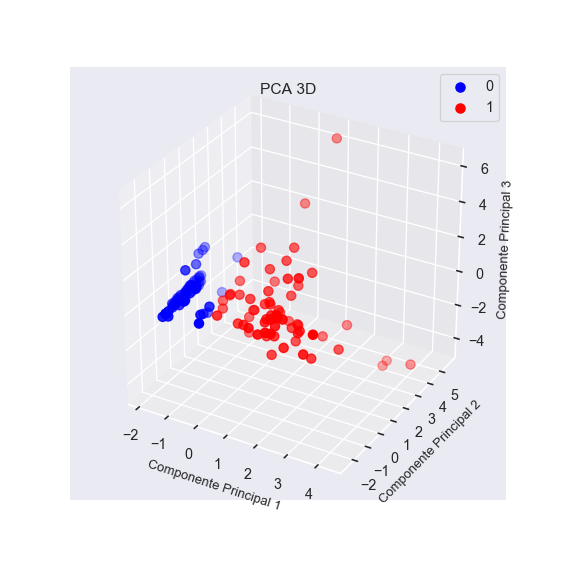

In [32]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
pca3=PCA(3)
compP3d=pca3.fit_transform(datos)
compPrin3d= pd.DataFrame(data=compP3d,
                          columns=['Componente1','Componente2','Componente3'])
compPrin3d=pd.concat([compPrin3d,datos[['Decisionlabel']]],axis=1)
fig = plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlabel('Componente Principal 1', fontsize=10)
ax1.set_ylabel('Componente Principal 2', fontsize=10)
ax1.set_zlabel('Componente Principal 3', fontsize=10)
ax1.set_title('PCA 3D',fontsize=12)
Salida=[0,1]
colors=['blue','red']
for TIPOCLIENTE, color in zip(Salida,colors):
    indicesToKeep = compPrin3d['Decisionlabel'] == TIPOCLIENTE
    ax1.scatter(compPrin3d.loc[indicesToKeep, 'Componente1']
               , compPrin3d.loc[indicesToKeep, 'Componente2']
               , compPrin3d.loc[indicesToKeep, 'Componente3']
               , c=color
               , s=50)
ax1.legend(Salida)
ax1.grid()
plt.show()
import warnings
warnings.simplefilter("ignore")

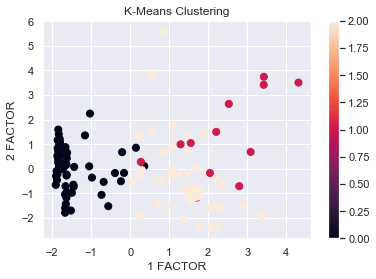

In [31]:
clust_labels, cent = doKmeans(principalDf, 3)
kmeans = pd.DataFrame(clust_labels)
kmeans
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(principalDf[0],principalDf[1],c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('1 FACTOR')
ax.set_ylabel('2 FACTOR')
plt.colorbar(scatter)
